# Key Assumption

The volatility between price show how the market feels - and might help us guess what happens next and do a decision.

#  Sub-Assumption

1. If a candle has a much bigger range than usual, it might mean a breakout or trend is starting.
2. If a market is moving a lot today, it will probably keep moving a lot tomorrow too.
3. if the shadows are large compared to the full candle, it means the market is unsure - price was pushed away from the highs/lows. That could mean a potential reversal.


# Hypothesis

Volatility patterns from candlestick data (range, continuation, and shadow size) reflect market behaviour, and can be used to anticipate breakouts, continuations, or reversals.

# Formula Calculation

SignalScore = w1 * RangeVol + w2 * VolCluster - w3 * WickRatio

where;

    - RangeVol = High - Low
    - VolCluster = VolCluster = std(Close - N:t)
    - WickRatio = (High - max(open,close) + min(open,close) - low) / (high - low + e)

# Load Data, Check Data whether is null or not

In [4]:
!pip install cybotrade_datasource
!pip install python-dotenv
!pip install hmmlearn

import pandas as pd
import numpy as np
import asyncio
import cybotrade_datasource
from datetime import datetime, timezone
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import warnings as wr
wr.filterwarnings('ignore')

print(dir(cybotrade_datasource))

load_dotenv()

API_KEY = os.getenv('CYBOTRADE_API_KEY')

'''
async def main():
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic='cryptoquant|btc/inter-entity-flows/miner-to-miner?from_miner=f2pool&to_miner=all_miner&window=hour', 
        start_time=datetime(year=2024, month=1, day=1, tzinfo=timezone.utc),
        end_time=datetime(year=2025, month=1, day=1, tzinfo=timezone.utc)
    )
    df = pd.DataFrame(data)
    print(df)
    

await main()
'''

'''
async def main():
    stream = await cybotrade_datasource.stream(
        api_key=API_KEY,
        topics=[
            'cryptoquant|btc/inter-entity-flows/miner-to-miner?from_miner=f2pool&to_miner=all_miner&window=hour',
            'cryptoquant|btc/market-data/liquidations?exchange=deribit&window=min',
        ],
    )
    async for msg in stream:
        print(msg)
    

await main()
'''

global_df = None 

async def get_data(topic):
    data = await cybotrade_datasource.query_paginated(
        api_key=API_KEY, 
        topic=topic, 
        limit=10000
    )
    return pd.DataFrame(data)


async def main():
    global global_df

    topics = [
        "bybit-linear|candle?symbol=BTCUSDT&interval=1m",
    ]

#topic
#"cryptoquant|btc/market-data/open-interest?exchange=bybit&window=min",
#bybit-linear|candle?interval=1m&symbol=BTCUSDT
#"cryptoquant|btc/market-data/coinbase-premium-index?window=hour",
#"cryptoquant|btc/exchange-flows/outflow?exchange=coinbase_advanced&window=hour",
#"glassnode|market/deltacap_usd?a=BTC&i=10m",

    tasks = [get_data(topic) for topic in topics]
    dataframes = await asyncio.gather(*tasks)

    for i, df in enumerate(dataframes):
        print(f"DataFrame {i+1} ({topics[i]})")
        print(df.head)
        print(df.isnull().sum())
        global_df = df

await main()


  Using cached hmmlearn-0.3.3-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
Using cached hmmlearn-0.3.3-cp311-cp311-win_amd64.whl (127 kB)
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cybotrade_datasource', 'query', 'query_paginated', 'stream']
DataFrame 1 (bybit-linear|candle?symbol=BTCUSDT&interval=1m)
<bound method NDFrame.head of          start_time    close     high      low     open   volume
0     1743752220000  83575.9  83635.0  83566.5  83627.9   52.951
1     1743752280000  83633.2  83633.2  83575.9  83575.9   26.825
2     1743752340000  83605.0  83633.2  83588.2  83633.2   35.183
3     1743752400000  83587.2  83620.0  83587.2  83605.0   37.969
4     1743752460000  83634.8  83634.8  83583.1  83587.2   24.781
...             ...      ...      ...      ...      ...      ...
9995  1744351920000  81110.7  81148.9  81102.0  81124.5   74.972
9996  1744351980000  81080.0  81155.1  81079.9  81110.7  142.805
9997  

Display first five column of the dataframe

In [5]:
print(global_df)

         start_time    close     high      low     open   volume
0     1743752220000  83575.9  83635.0  83566.5  83627.9   52.951
1     1743752280000  83633.2  83633.2  83575.9  83575.9   26.825
2     1743752340000  83605.0  83633.2  83588.2  83633.2   35.183
3     1743752400000  83587.2  83620.0  83587.2  83605.0   37.969
4     1743752460000  83634.8  83634.8  83583.1  83587.2   24.781
...             ...      ...      ...      ...      ...      ...
9995  1744351920000  81110.7  81148.9  81102.0  81124.5   74.972
9996  1744351980000  81080.0  81155.1  81079.9  81110.7  142.805
9997  1744352040000  81073.1  81080.0  81064.6  81080.0   47.633
9998  1744352100000  81068.5  81135.5  81068.5  81073.1   50.855
9999  1744352160000  81031.8  81076.9  81007.2  81068.5   66.907

[10000 rows x 6 columns]


Analyze Data (first five and last five)

In [6]:
global_df.head()

,start_time,close,high,low,open,volume
0,1743752220000,83575.9,83635.0,83566.5,83627.9,52.951
1,1743752280000,83633.2,83633.2,83575.9,83575.9,26.825
2,1743752340000,83605.0,83633.2,83588.2,83633.2,35.183
3,1743752400000,83587.2,83620.0,83587.2,83605.0,37.969
4,1743752460000,83634.8,83634.8,83583.1,83587.2,24.781


In [7]:
global_df.tail()

,start_time,close,high,low,open,volume
9995,1744351920000,81110.7,81148.9,81102.0,81124.5,74.972
9996,1744351980000,81080.0,81155.1,81079.9,81110.7,142.805
9997,1744352040000,81073.1,81080.0,81064.6,81080.0,47.633
9998,1744352100000,81068.5,81135.5,81068.5,81073.1,50.855
9999,1744352160000,81031.8,81076.9,81007.2,81068.5,66.907


In [8]:
global_df.shape

(10000, 6)

In [9]:
num_rows = len(global_df)
print(num_rows)

10000


We had 10000 rows in this dataset (latest)

In [10]:
cat_cols = global_df.select_dtypes(include=['object']).columns
num_cols = global_df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index([], dtype='object')
Numerical Variables:
['start_time', 'close', 'high', 'low', 'open', 'volume']


In [11]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_time  10000 non-null  int64  
 1   close       10000 non-null  float64
 2   high        10000 non-null  float64
 3   low         10000 non-null  float64
 4   open        10000 non-null  float64
 5   volume      10000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 468.9 KB


Obtain a statistical summary of the dataframe using describe

In [12]:
global_df.describe()

,start_time,close,high,low,open,volume
count,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.744052e+12,80509.343560,80559.36826,80460.966320,80509.603170,121.248364
std,1.732137e+08,2609.841927,2593.38639,2626.280909,2610.023018,209.373830
min,1.743752e+12,74584.200000,74702.50000,74456.200000,74584.200000,0.946000
25%,1.743902e+12,78393.050000,78466.47500,78304.550000,78393.050000,27.431250
50%,1.744052e+12,80583.000000,80632.50000,80537.700000,80583.000000,61.904500
75%,1.744202e+12,82938.325000,82970.00000,82905.900000,82939.025000,136.664750
max,1.744352e+12,84670.200000,84736.00000,84656.100000,84670.200000,4595.508000


In [13]:
global_df.describe(include='all')

,start_time,close,high,low,open,volume
count,1.000000e+04,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.744052e+12,80509.343560,80559.36826,80460.966320,80509.603170,121.248364
std,1.732137e+08,2609.841927,2593.38639,2626.280909,2610.023018,209.373830
min,1.743752e+12,74584.200000,74702.50000,74456.200000,74584.200000,0.946000
25%,1.743902e+12,78393.050000,78466.47500,78304.550000,78393.050000,27.431250
50%,1.744052e+12,80583.000000,80632.50000,80537.700000,80583.000000,61.904500
75%,1.744202e+12,82938.325000,82970.00000,82905.900000,82939.025000,136.664750
max,1.744352e+12,84670.200000,84736.00000,84656.100000,84670.200000,4595.508000


In [14]:
num_rows = global_df.shape[0]
num_cols = global_df.shape[1]
print("Rows: ", num_rows, "Columns: ", num_cols)


Rows:  10000 Columns:  6


Show columns's data types using the property df.dtypes

In [15]:
global_df.dtypes

start_time      int64
close         float64
high          float64
low           float64
open          float64
volume        float64
dtype: object

In [16]:
summary_stats = global_df.describe()
print(summary_stats)

         start_time         close         high           low          open  \
count  1.000000e+04  10000.000000  10000.00000  10000.000000  10000.000000   
mean   1.744052e+12  80509.343560  80559.36826  80460.966320  80509.603170   
std    1.732137e+08   2609.841927   2593.38639   2626.280909   2610.023018   
min    1.743752e+12  74584.200000  74702.50000  74456.200000  74584.200000   
25%    1.743902e+12  78393.050000  78466.47500  78304.550000  78393.050000   
50%    1.744052e+12  80583.000000  80632.50000  80537.700000  80583.000000   
75%    1.744202e+12  82938.325000  82970.00000  82905.900000  82939.025000   
max    1.744352e+12  84670.200000  84736.00000  84656.100000  84670.200000   

             volume  
count  10000.000000  
mean     121.248364  
std      209.373830  
min        0.946000  
25%       27.431250  
50%       61.904500  
75%      136.664750  
max     4595.508000  


# Data Cleaning


In [17]:
global_df['start_time'] = pd.to_datetime(global_df['start_time'], unit='ms')


print(global_df[['start_time']])

              start_time
0    2025-04-04 07:37:00
1    2025-04-04 07:38:00
2    2025-04-04 07:39:00
3    2025-04-04 07:40:00
4    2025-04-04 07:41:00
...                  ...
9995 2025-04-11 06:12:00
9996 2025-04-11 06:13:00
9997 2025-04-11 06:14:00
9998 2025-04-11 06:15:00
9999 2025-04-11 06:16:00

[10000 rows x 1 columns]


In [18]:
global_df.head()

,start_time,close,high,low,open,volume
0,2025-04-04 07:37:00,83575.9,83635.0,83566.5,83627.9,52.951
1,2025-04-04 07:38:00,83633.2,83633.2,83575.9,83575.9,26.825
2,2025-04-04 07:39:00,83605.0,83633.2,83588.2,83633.2,35.183
3,2025-04-04 07:40:00,83587.2,83620.0,83587.2,83605.0,37.969
4,2025-04-04 07:41:00,83634.8,83634.8,83583.1,83587.2,24.781


In [19]:
global_df.tail()

,start_time,close,high,low,open,volume
9995,2025-04-11 06:12:00,81110.7,81148.9,81102.0,81124.5,74.972
9996,2025-04-11 06:13:00,81080.0,81155.1,81079.9,81110.7,142.805
9997,2025-04-11 06:14:00,81073.1,81080.0,81064.6,81080.0,47.633
9998,2025-04-11 06:15:00,81068.5,81135.5,81068.5,81073.1,50.855
9999,2025-04-11 06:16:00,81031.8,81076.9,81007.2,81068.5,66.907


In [20]:
print(global_df)

              start_time    close     high      low     open   volume
0    2025-04-04 07:37:00  83575.9  83635.0  83566.5  83627.9   52.951
1    2025-04-04 07:38:00  83633.2  83633.2  83575.9  83575.9   26.825
2    2025-04-04 07:39:00  83605.0  83633.2  83588.2  83633.2   35.183
3    2025-04-04 07:40:00  83587.2  83620.0  83587.2  83605.0   37.969
4    2025-04-04 07:41:00  83634.8  83634.8  83583.1  83587.2   24.781
...                  ...      ...      ...      ...      ...      ...
9995 2025-04-11 06:12:00  81110.7  81148.9  81102.0  81124.5   74.972
9996 2025-04-11 06:13:00  81080.0  81155.1  81079.9  81110.7  142.805
9997 2025-04-11 06:14:00  81073.1  81080.0  81064.6  81080.0   47.633
9998 2025-04-11 06:15:00  81068.5  81135.5  81068.5  81073.1   50.855
9999 2025-04-11 06:16:00  81031.8  81076.9  81007.2  81068.5   66.907

[10000 rows x 6 columns]


In [21]:
global_df.dtypes

start_time    datetime64[ns]
close                float64
high                 float64
low                  float64
open                 float64
volume               float64
dtype: object

In [22]:
global_df.isnull().sum()

start_time    0
close         0
high          0
low           0
open          0
volume        0
dtype: int64

Percentage of missing value

In [23]:
(global_df.isnull().sum()/(len(global_df)))*100

start_time    0.0
close         0.0
high          0.0
low           0.0
open          0.0
volume        0.0
dtype: float64

Check duplicate value

In [24]:
global_df.count()

start_time    10000
close         10000
high          10000
low           10000
open          10000
volume        10000
dtype: int64

In [25]:
global_df.nunique()

start_time    10000
close          9042
high           8657
low            8633
open           9042
volume         9776
dtype: int64

In [26]:
duplicate_rows = global_df.duplicated()

# Display rows with duplicates
duplicate_rows_df = global_df[duplicate_rows]
print(duplicate_rows_df)

Empty DataFrame
Columns: [start_time, close, high, low, open, volume]
Index: []


In [27]:
global_df.head()

,start_time,close,high,low,open,volume
0,2025-04-04 07:37:00,83575.9,83635.0,83566.5,83627.9,52.951
1,2025-04-04 07:38:00,83633.2,83633.2,83575.9,83575.9,26.825
2,2025-04-04 07:39:00,83605.0,83633.2,83588.2,83633.2,35.183
3,2025-04-04 07:40:00,83587.2,83620.0,83587.2,83605.0,37.969
4,2025-04-04 07:41:00,83634.8,83634.8,83583.1,83587.2,24.781


Exploratory Data Analysis

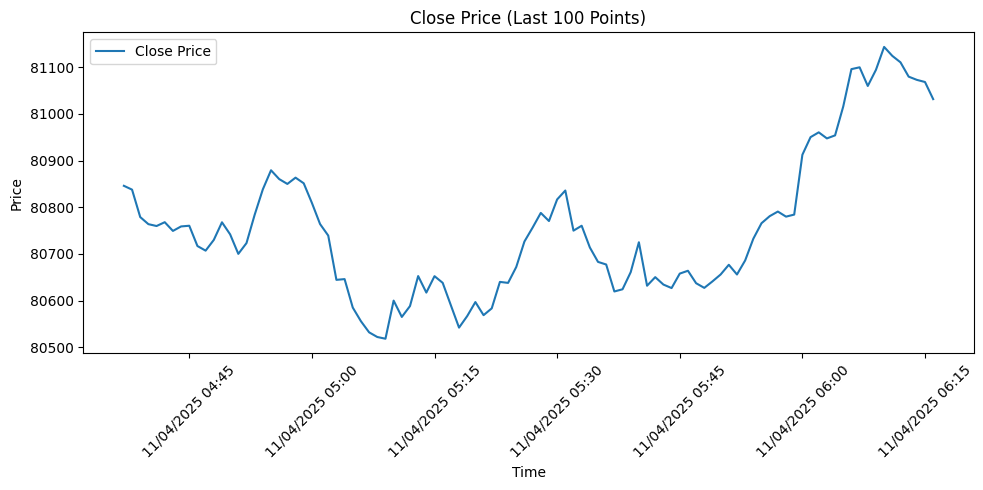

In [28]:
from matplotlib.dates import DateFormatter

# Convert your time column
global_df['start_time'] = pd.to_datetime(global_df['start_time'])

# Get last 100 rows
df_last = global_df.tail(100)

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_last['start_time'], df_last['close'], label='Close Price')

# Set custom date format
date_fmt = DateFormatter('%d/%m/%Y %H:%M')  # Example: 10/04/2025 07:45
ax.xaxis.set_major_formatter(date_fmt)

# Labeling
ax.set_title('Close Price (Last 100 Points)')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Uptrend (approx. 09:25–09:45): The price shows a gradual and consistent increase, suggesting positive market sentiment or buying pressure.

Volatility Phase (approx. 09:45–10:00): Sharp up and down fluctuations in close price. This often suggests indecision, possible news events, or liquidity imbalances.

Downtrend (approx. 10:00–10:30): Clear and sharp drop in price.
May signal profit-taking, bearish sentiment, or reversal of earlier gains.

Mild Recovery (approx. 10:30–11:00): After hitting a low, price slightly rises again. Indicates attempt to regain confidence, but still uncertain.

# Extract Features (hmm model) - Volatility Factors

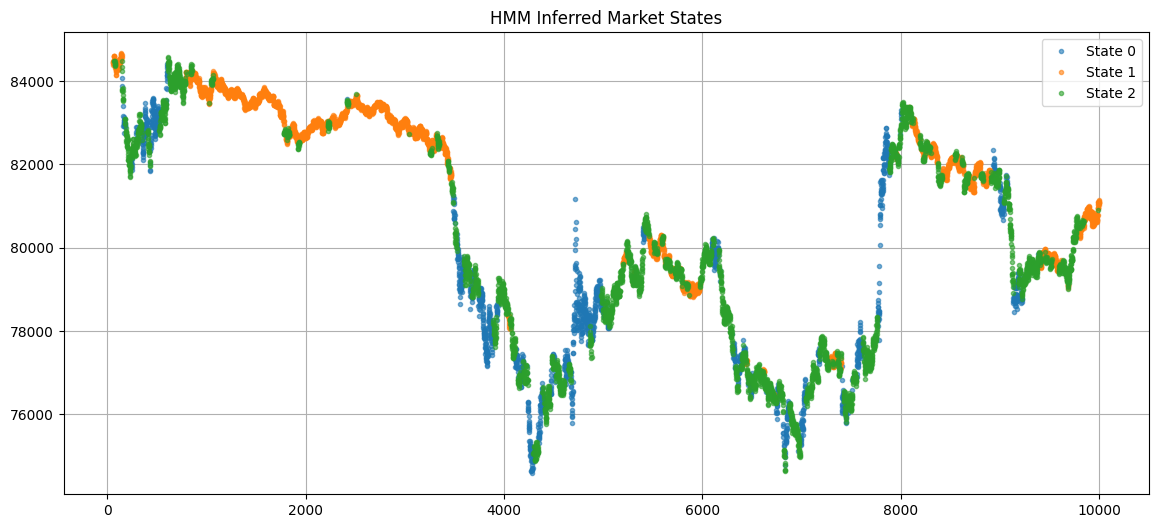

In [ ]:
def extract_features(global_df, window=14):
    global_df = global_df.copy()
    global_df['log_return'] = np.log(global_df['close'] / global_df['close'].shift(1))
    global_df['volatility'] = global_df['log_return'].rolling(window=window).std()
    global_df['price_range'] = global_df['high'] - global_df['low']

    global_df['ma_trend'] = global_df['close'].rolling(window=60).mean()  
    global_df['trend_signal'] = (global_df['close'] > global_df['ma_trend']).astype(int)  

    global_df['log_volume'] = np.log(global_df['volume'] + 1)

    global_df.dropna(inplace=True)
    return global_df

def train_hmm(global_df, n_states=3):
    features = ['log_return', 'volatility', 'log_volume', 'price_range']
    X = global_df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000)
    model.fit(X_scaled)

    hidden_states = model.predict(X_scaled)
    global_df = global_df.copy()
    global_df['state'] = hidden_states
    return model, scaler, global_df

def plot_states(global_df, n_states):
    plt.figure(figsize=(14, 6))
    for i in range(n_states):
        state = global_df[global_df['state'] == i]
        plt.plot(state.index, state['close'], '.', label=f'State {i}', alpha=0.6)
    plt.legend()
    plt.title("HMM Inferred Market States")
    plt.grid(True)
    plt.show()

global_df_raw = global_df.copy()

global_df_feat = extract_features(global_df_raw, window=14)

hmm_model, scaler, global_df_result = train_hmm(global_df_feat, n_states=3)

plot_states(global_df_result, n_states=3)

# Backtest - Volatility model

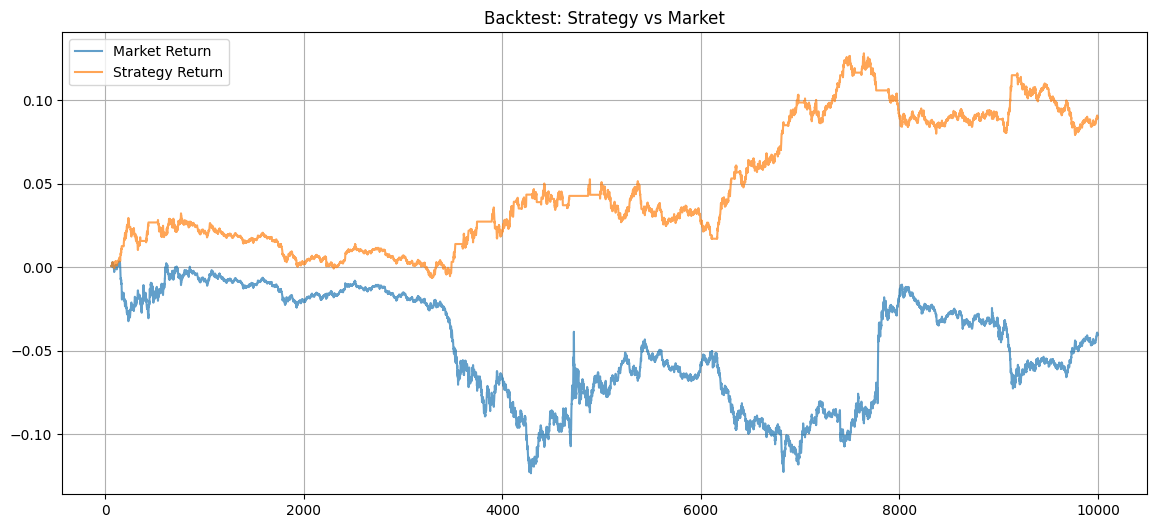

In [ ]:
def backtest(global_df, position_map):
    """
    df: 包含 'close' 和 'state' 的 dataframe
    position_map: dict，比如 {0: 0, 1: 1, 2: -1}
    """
    global_df = global_df.copy()
    global_df['log_return'] = np.log(global_df['close'] / global_df['close'].shift(1))
    global_df['position'] = global_df['state'].map(position_map)
    global_df['strategy_return'] = global_df['position'].shift(1) * global_df['log_return']
    global_df.dropna(inplace=True)

    cum_strategy = global_df['strategy_return'].cumsum()
    cum_market = global_df['log_return'].cumsum()

    return global_df, cum_market, cum_strategy

def plot_backtest(global_df, cum_market, cum_strategy):
    plt.figure(figsize=(14, 6))
    plt.plot(global_df.index, cum_market, label="Market Return", alpha=0.7)
    plt.plot(global_df.index, cum_strategy, label="Strategy Return", alpha=0.7)
    plt.title("Backtest: Strategy vs Market")
    plt.legend()
    plt.grid(True)
    plt.show()

position_map = {0: 0, 1: 1, 2: -1}  

global_df_backtested, cum_mkt, cum_strat = backtest(global_df_result, position_map)
plot_backtest(global_df_backtested, cum_mkt, cum_strat)

def evaluate_performance(df):
    sharpe = global_df['strategy_return'].mean() / global_df['strategy_return'].std() * np.sqrt(252*24*60)  # 如果是1min数据
    max_drawdown = (global_df['strategy_return'].cumsum().cummax() - global_df['strategy_return'].cumsum()).max()

    print(f"Strategy Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")